In [3]:
import pandas as pd
import os

In [4]:
data_dir = 'ohlc_data'

In [5]:
raw_data = pd.read_csv(os.path.join(os.getcwd(), 'Cleaned_Signal_EURUSD_for_training.csv'))

In [7]:
df = raw_data
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
df['Date'] = pd.to_datetime(df['time'], unit='s')   
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Signal']]
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume,Signal
Date,,,,,,
2014-12-31 18:00:00,1.20997,1.21089,1.20966,1.20999,3237,0
2015-01-02 08:00:00,1.20481,1.20569,1.20479,1.20538,1254,0
2015-01-02 09:00:00,1.20537,1.20574,1.20341,1.20553,3394,0
2015-01-02 10:00:00,1.20556,1.20689,1.20442,1.20469,4590,0
2015-01-02 11:00:00,1.20468,1.20599,1.20380,1.20573,4335,0
...,...,...,...,...,...,...
2024-12-20 10:00:00,1.03816,1.03974,1.03770,1.03913,5104,1
2024-12-20 11:00:00,1.03913,1.03915,1.03749,1.03817,4389,1
2024-12-20 12:00:00,1.03818,1.03921,1.03803,1.03908,3521,1


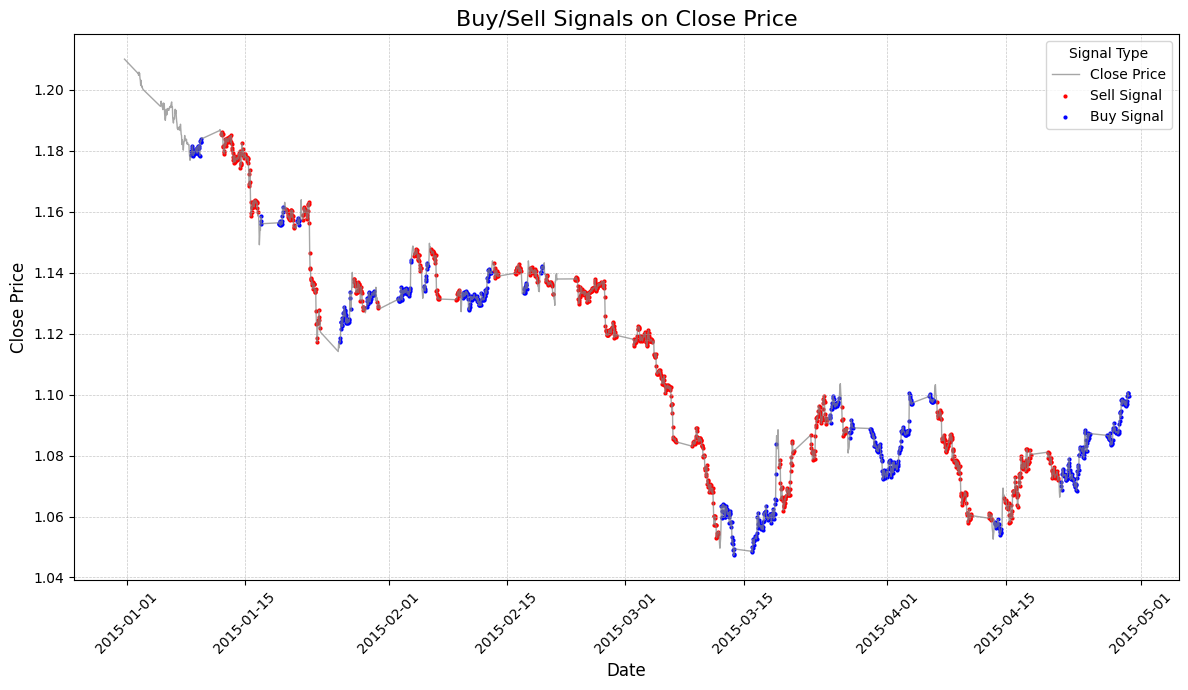

In [9]:
generate_plot(df, val_limit=2000)

In [8]:
def generate_plot(data_plot, val_limit=5000):
    df = data_plot.iloc[:val_limit, :].copy()
    # Plot Close Prices and signals
    plt.figure(figsize=(12, 7))
    plt.plot(df.index, df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)
    # plt.plot(df.index, df['Lower_Band'], c='red', alpha=0.7, label='Lower_Band', linewidth=1)
    # plt.plot(df.index, df['Upper_Band'], c='blue', alpha=0.7, label='Upper_Band', linewidth=1)

    # Combine Buy and Sell Signals
    signals = df[df['Signal'] != 0]

    # Plot Sell Signals
    sell_signals = signals[signals['Signal'] == -1]
    plt.scatter(sell_signals.index, sell_signals['Close'], c='red', label='Sell Signal', marker='o', s=4)

    # Plot Buy Signals
    buy_signals = signals[signals['Signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['Close'], c='blue', label='Buy Signal', marker='o', s=4)

    # Chart Customization
    plt.title('Buy/Sell Signals on Close Price', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Signal Type')
    plt.tight_layout()
    plt.show()

In [53]:
raw_data = df

In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from scipy.signal import argrelextrema

from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [45]:
# file_name = 'merged_data.csv'
file_name = '0_61938.csv'
data_path = os.path.join(os.getcwd(), data_dir, file_name)

data_0_61938 = pd.read_csv(data_path, index_col=0)
data_0_61938.reset_index(drop=True, inplace=True)
data_0_61938.head()

,Open,High,Low,Close,Volume,Time,Date,Signal,Moving_Avg,Upper_Band,Lower_Band
0,1.20997,1.21089,1.20966,1.20999,3237,2014-12-31 18:00:00,2014-12-31 18:00:00,0,NaN,NaN,NaN
1,1.20481,1.20569,1.20479,1.20538,1254,2015-01-02 08:00:00,2015-01-02 08:00:00,0,NaN,NaN,NaN
2,1.20537,1.20574,1.20341,1.20553,3394,2015-01-02 09:00:00,2015-01-02 09:00:00,0,NaN,NaN,NaN
3,1.20556,1.20689,1.20442,1.20469,4590,2015-01-02 10:00:00,2015-01-02 10:00:00,0,NaN,NaN,NaN
4,1.20468,1.20599,1.20380,1.20573,4335,2015-01-02 11:00:00,2015-01-02 11:00:00,0,NaN,NaN,NaN


In [64]:
data_0_61938['Signal'].value_counts()

Signal
0    59856
2     1060
1     1022
Name: count, dtype: int64

In [10]:
data = raw_data

In [11]:
data['Signal'].value_counts()

Signal
 0    27544
-1    17503
 1    16891
Name: count, dtype: int64

In [12]:
data['Signal'] = data['Signal'].replace({1: 2, -1: 1})

###  Desired logic:
#### Initially all zeros.
#### When you hit a 1 or 2, keep repeating that value until the next non-zero (different) signal appears.
#### If 0 appears after a 1 or 2, treat it as "repeat the last non-zero". 
#### Propagate the last non-zero signal forward until a new one appears.
#### If any span of a propagated signal (1 or 2) is less than 10 in length, replace it with 0.

In [26]:
# import numpy as np

# # Input signal (replace with your actual data)
# signal = np.array([
#     0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
#     0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#     1, 0, 0, 0
# ], dtype=int)

signal = data.Signal.values
Threshold = 100

# Step 1: Propagate signals forward
output = np.zeros_like(signal)
last = 0
for i, val in enumerate(signal):
    if val != 0:
        last = val
    output[i] = last
print('Before', output)
# Step 2: Remove short signal spans (less than 10)
i = 0
while i < len(output):
    val = output[i]
    if val == 0:
        i += 1
        continue
    # Count span length
    start = i
    while i < len(output) and output[i] == val:
        i += 1
    end = i
    span = end - start
    if span < Threshold:
        output[start:end] = 0

# print(output)


Before [0 0 0 ... 1 1 1]


In [ ]:
data['signal_balanced'] = output

data['signal_balanced'].value_counts()

In [ ]:
# file_name = 'merged_data.csv'
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
data_path = os.path.join(os.getcwd(), data_dir, file_name)

data = pd.read_csv(data_path, index_col=0)
data.reset_index(drop=True, inplace=True)




In [13]:
data.reset_index(drop=True, inplace=True)

data

,time,Open,High,Low,Close,Volume,spread,real_volume,Signal,ATR,Date
0,1420048800,1.20997,1.21089,1.20966,1.20999,3237,17,0,0,0.000000,2014-12-31 18:00:00
1,1420185600,1.20481,1.20569,1.20479,1.20538,1254,17,0,0,0.000000,2015-01-02 08:00:00
2,1420189200,1.20537,1.20574,1.20341,1.20553,3394,17,0,0,0.000000,2015-01-02 09:00:00
3,1420192800,1.20556,1.20689,1.20442,1.20469,4590,17,0,0,0.000000,2015-01-02 10:00:00
4,1420196400,1.20468,1.20599,1.20380,1.20573,4335,17,0,0,0.000000,2015-01-02 11:00:00
...,...,...,...,...,...,...,...,...,...,...,...
61933,1734688800,1.03816,1.03974,1.03770,1.03913,5104,17,0,2,0.001488,2024-12-20 10:00:00
61934,1734692400,1.03913,1.03915,1.03749,1.03817,4389,17,0,2,0.001500,2024-12-20 11:00:00
61935,1734696000,1.03818,1.03921,1.03803,1.03908,3521,17,0,2,0.001477,2024-12-20 12:00:00
61936,1734699600,1.03908,1.03964,1.03785,1.03906,3663,17,0,2,0.001500,2024-12-20 13:00:00


In [19]:
features_df = feature_generate(data)

In [20]:
features_df.columns

Index(['time', 'Open', 'High', 'Low', 'Close', 'Volume', 'spread',
       'real_volume', 'Signal', 'ATR', 'Date', 'SMA_5', 'EMA_5', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100',
       'SMA_200', 'EMA_200', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
       'Williams_%R', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Plus_DI',
       'Minus_DI', 'ADX', 'CCI', 'Bollinger_Mid', 'Bollinger_Upper',
       'Bollinger_Lower', 'ROC', 'OBV', 'Force_Index', 'ADL', 'MFI', 'ASI',
       'Chaikin_Oscillator', 'RS', 'Keltner_Mid', 'Keltner_Upper',
       'Keltner_Lower', 'Donchian_Upper', 'Donchian_Lower', 'Fib_0', 'Fib_100',
       'Fib_50', 'Fib_61.8', 'Fib_38.2', 'Pivot_Point', 'Pivot_R1', 'Pivot_S1',
       'Pivot_R2', 'Pivot_S2', 'EMA50', 'EMA200', 'Donchian_High',
       'Donchian_Low', 'Local_Max', 'Local_Min'],
      dtype='object')

In [21]:
features_df.isna().any(axis=1).sum()

199

In [22]:
features_df = features_df.fillna(method='ffill').fillna(method='bfill')

In [23]:
len(features_df)

61938

In [24]:
features_df_nonan = features_df.dropna().reset_index(drop=True)
selected_features_, feat_idx_ = features_selection(features_df_nonan)

Features removed due to high correlation: ['Donchian_Lower', 'Donchian_Upper', 'EMA_20', 'EMA_200', 'EMA_5', 'EMA_50', 'Fib_0', 'Fib_50', 'Fib_61.8', 'Keltner_Mid', 'Pivot_Point', 'Pivot_R1', 'Pivot_R2', 'Pivot_S1', 'Pivot_S2', 'SMA_10', 'SMA_20', 'SMA_5', 'Williams_%R']


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.570478725054272, tolerance: 3.4024320887991957
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.091114916627703, tolerance: 3.4024320887991957
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.155010668193427, tolerance: 3.4024320887991957
  model = cd_fast.enet_coordinate_descent

Features selected by Lasso: ['ADL', 'ATR', 'CCI', 'Local_Max', 'Local_Min', 'MACD_Hist', 'OBV', 'Volume']
Feature indices for common features: [4, 7, 18, 22, 27, 29, 42, 43]


In [26]:
selected_features_

['ADL', 'ATR', 'CCI', 'Local_Max', 'Local_Min', 'MACD_Hist', 'OBV', 'Volume']

In [27]:
feat_idx_in_original = [features_df_nonan.columns.get_loc(c) for c in selected_features_]
features_df_nonan.iloc[:, feat_idx_in_original].head()

,ADL,ATR,CCI,Local_Max,Local_Min,MACD_Hist,OBV,Volume
0,-1500.073171,0.002083,-92.677374,0,0,0.000000,0,3237
1,-1109.939837,0.002083,-92.677374,0,0,-0.000294,-1254,1254
2,1672.266171,0.002083,-92.677374,0,0,-0.000453,2140,3394
3,-1914.252047,0.002083,-92.677374,0,0,-0.000581,-2450,4590
4,1391.432884,0.002083,-92.677374,0,0,-0.000561,1885,4335


In [33]:
epoch = 10

model_name = os.path.join(os.getcwd(), data_dir)
xTest, yTest_onehot, history_, model_path, scaler_ = prepare_train_model(
    features_df_nonan.iloc[:, feat_idx_in_original], 
    features_df_nonan['Signal'],
    epoch,
    model_name)



Class Label: 0 -> One-Hot Encoding: [1. 0. 0.]
Class Label: 1 -> One-Hot Encoding: [0. 1. 0.]
Class Label: 2 -> One-Hot Encoding: [0. 0. 1.]
Epoch 1/10
1239/1239 [==============================] - 9s 5ms/step - loss: 0.8872 - accuracy: 0.6013 - val_loss: 0.7470 - val_accuracy: 0.6792
Epoch 2/10
1239/1239 [==============================] - 5s 4ms/step - loss: 0.7907 - accuracy: 0.6670 - val_loss: 0.7118 - val_accuracy: 0.6933
Epoch 3/10
1239/1239 [==============================] - 6s 5ms/step - loss: 0.7790 - accuracy: 0.6724 - val_loss: 0.7295 - val_accuracy: 0.6862
Epoch 4/10
1239/1239 [==============================] - 5s 4ms/step - loss: 0.7739 - accuracy: 0.6770 - val_loss: 0.7173 - val_accuracy: 0.6897
Epoch 5/10
1239/1239 [==============================] - 6s 5ms/step - loss: 0.7692 - accuracy: 0.6786 - val_loss: 0.7386 - val_accuracy: 0.6793
Epoch 6/10
1239/1239 [==============================] - 6s 5ms/step - loss: 0.7693 - accuracy: 0.6790 - val_loss: 0.7337 - val_accuracy: 0.

INFO:tensorflow:Assets written to: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\model.hd5\assets


In [31]:
epoch = 10

model_name = os.path.join(os.getcwd(), data_dir)
xTest, yTest_onehot, history_, model_path, scaler_ = prepare_train_model_new(
    features_df_nonan.iloc[:, feat_idx_in_original], 
    features_df_nonan['Signal'],
    epoch,
    model_name)

Epoch 1/10
1652/1652 [==============================] - 28s 14ms/step - loss: 0.6613 - accuracy: 0.7235 - val_loss: 0.4672 - val_accuracy: 0.8235
Epoch 2/10
1652/1652 [==============================] - 23s 14ms/step - loss: 0.4991 - accuracy: 0.8115 - val_loss: 0.5007 - val_accuracy: 0.8005
Epoch 3/10
1652/1652 [==============================] - 23s 14ms/step - loss: 0.4711 - accuracy: 0.8250 - val_loss: 0.4178 - val_accuracy: 0.8443
Epoch 4/10
1652/1652 [==============================] - 25s 15ms/step - loss: 0.4570 - accuracy: 0.8289 - val_loss: 0.4194 - val_accuracy: 0.8432
Epoch 5/10
1652/1652 [==============================] - 24s 14ms/step - loss: 0.4520 - accuracy: 0.8304 - val_loss: 0.4092 - val_accuracy: 0.8453
Epoch 6/10
1652/1652 [==============================] - 25s 15ms/step - loss: 0.4411 - accuracy: 0.8360 - val_loss: 0.4085 - val_accuracy: 0.8438
Epoch 7/10
1652/1652 [==============================] - 22s 13ms/step - loss: 0.4353 - accuracy: 0.8385 - val_loss: 0.4091 -

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import tensorflow as tf

def prepare_train_model_new(df, df_signal, epc, model_saved_path, lookback=20):
    X = df.values
    y = df_signal.values

    # Create sliding window sequences
    x_seq = np.array([X[i-lookback+1:i+1] for i in range(lookback-1, len(X))])
    y_seq = y[lookback-1:]

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(
        x_seq, y_seq, train_size=0.8, shuffle=True, random_state=42, stratify=y_seq
    )

    # Apply SMOTE (flatten sequences for SMOTE)
    n_samples, timesteps, n_features = x_train.shape
    x_train_flat = x_train.reshape((n_samples, timesteps * n_features))
    smote = SMOTE(random_state=42, sampling_strategy='not majority')
    x_train_res, y_train_res = smote.fit_resample(x_train_flat, y_train)
    x_train = x_train_res.reshape((-1, timesteps, n_features))
    y_train = y_train_res

    # Split validation from training
    train_split = 0.9 if 0.8 * x_train.shape[0] < 2500 else 0.8
    x_train, x_cv, y_train, y_cv = train_test_split(
        x_train, y_train, train_size=train_split, shuffle=True, random_state=42, stratify=y_train
    )

    # Scale per feature
    scaler = MinMaxScaler()
    n_samples_train = x_train.shape[0]
    x_train_2d = x_train.reshape(-1, n_features)
    x_train_scaled = scaler.fit_transform(x_train_2d).reshape(n_samples_train, timesteps, n_features)
    x_cv_scaled = scaler.transform(x_cv.reshape(-1, n_features)).reshape(x_cv.shape[0], timesteps, n_features)
    x_test_scaled = scaler.transform(x_test.reshape(-1, n_features)).reshape(x_test.shape[0], timesteps, n_features)

    # One-hot encode labels
    y_train_onehot = to_categorical(y_train, num_classes=3)
    y_cv_onehot = to_categorical(y_cv, num_classes=3)
    y_test_onehot = to_categorical(y_test, num_classes=3)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Build Conv1D + LSTM model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        x_train_scaled, y_train_onehot,
        epochs=epc,
        batch_size=32,
        validation_data=(x_cv_scaled, y_cv_onehot),
        class_weight=class_weight_dict
    )

    # Evaluate
    test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test_onehot)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save model
    os.makedirs(model_saved_path, exist_ok=True)
    model.save(os.path.join(model_saved_path, 'model.h5'))

    return x_test_scaled, y_test_onehot, history, model_saved_path, scaler


In [35]:
 features_df_nonan['Signal'].value_counts()

Signal
0    27544
1    17503
2    16891
Name: count, dtype: int64

In [41]:
xTest.shape

(12388, 31, 1)

In [42]:
model_path

'D:\\Repos_git\\Make_Money_with_Tensorflow_2.0\\forexPredictor\\ohlc_data'

In [28]:
predictions_accuracy_plot_new(xTest, yTest_onehot, history_, model_path)  

NameError: name 'xTest' is not defined

388/388 [==============================] - 1s 2ms/step
Predicted one hot: [1 2 0 1 1 0 2 0 1 1 0 2 2 2 0 2 0 0 0 0 0 2 2 2 1 0 0 2 2 0 0 0 2 1 2 2 1
 0 0 2 0 0 2 1 2 0 0 1 1 0]
Actual one hot: [0 2 0 0 0 0 2 0 2 2 0 2 0 2 2 1 0 0 0 0 0 2 2 2 1 0 0 0 1 0 0 2 2 0 2 1 1
 1 0 0 0 0 1 1 0 2 2 1 1 0]
[[4380  556  573]
 [ 456 2101  944]
 [ 419  756 2203]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      5509
           1       0.62      0.60      0.61      3501
           2       0.59      0.65      0.62      3378

    accuracy                           0.70     12388
   macro avg       0.68      0.68      0.68     12388
weighted avg       0.71      0.70      0.70     12388



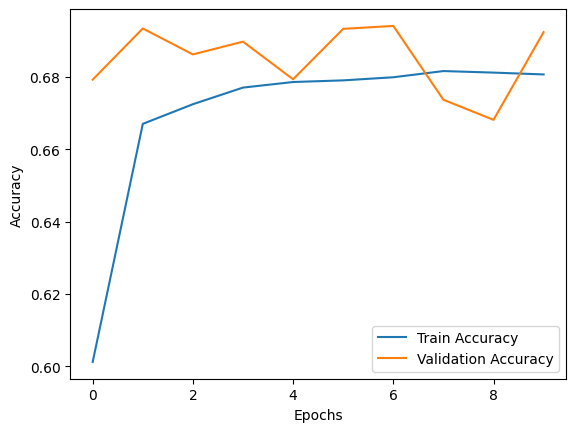

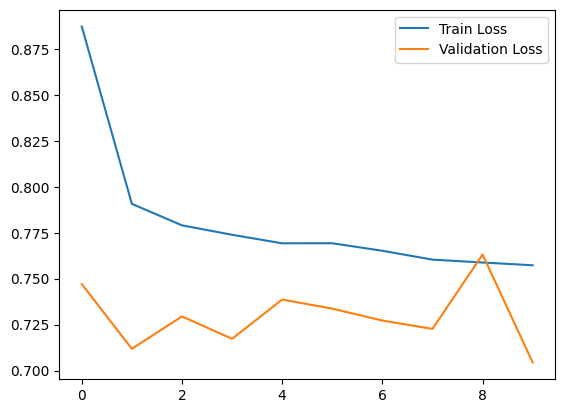

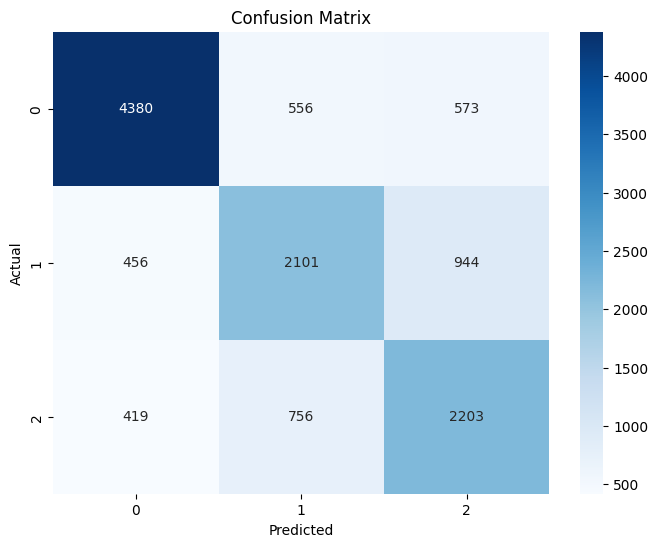

In [36]:
predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)  

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(x_test, y_test_classes, y_pred_classes, sample_count=50):
    """
    Plots actual vs predicted classes for the first `sample_count` samples.
    """
    # Limit to requested number of samples
    indices = np.arange(min(sample_count, len(x_test)))

    plt.figure(figsize=(12, 5))
    
    # Plot actual classes
    plt.plot(indices, y_test_classes[:len(indices)], 'go-', label='Actual Class')
    # Plot predicted classes
    plt.plot(indices, y_pred_classes[:len(indices)], 'ro-', label='Predicted Class')
    
    plt.xlabel("Sample Index")
    plt.ylabel("Class")
    plt.title("Predicted vs Actual Classes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage after predictions
# y_pred_probs = model.predict(x_test)
# y_pred_classes = np.argmax(y_pred_probs, axis=1)
# y_test_classes = np.argmax(y_test_onehot, axis=1)
# plot_predictions_vs_actual(x_test, y_test_classes, y_pred_classes, sample_count=50)


In [45]:
# Load the trained model (fixed filename extension)
model_path = os.path.join(model_path, 'model.h5')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")
model = load_model(model_path)

# Example usage after predictions
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)
plot_predictions_vs_actual(x_test, y_test_classes, y_pred_classes, sample_count=50)


NameError: name 'x_test' is not defined

In [30]:
def prepare_train_model(df, df_signal, epc, model_saved_path):
    # Use all numeric columns from df
    X = df.values
    y = df_signal.values

    # Split data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=0.8, 
        test_size=0.2, 
        random_state=2, 
        shuffle=True, 
        stratify=y
    )

    # Handle class imbalance with SMOTE
    # smote = SMOTE(random_state=42, sampling_strategy='not majority')
    # x_train, y_train = smote.fit_resample(x_train, y_train)

    # Dynamic train-validation split
    train_split = 0.9 if 0.8 * x_train.shape[0] < 2500 else 0.8
    x_train, x_cv, y_train, y_cv = train_test_split(
        x_train, y_train, 
        train_size=train_split, 
        test_size=1-train_split, 
        random_state=2, 
        shuffle=True, 
        stratify=y_train
    )

    # Scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_train = scaler.fit_transform(x_train)
    x_cv = scaler.transform(x_cv)
    x_test = scaler.transform(x_test)

    # Reshape for Conv1D: single timestep, features as channels
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_cv = x_cv.reshape((x_cv.shape[0], 1, x_cv.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    # Normalize if needed
    x_train = x_train / np.max(x_train)
    x_cv = x_cv / np.max(x_cv)
    x_test = x_test / np.max(x_test)

    # One-hot encode labels
    y_train_onehot = to_categorical(y_train, num_classes=3)
    y_cv_onehot = to_categorical(y_cv, num_classes=3)
    y_test_onehot = to_categorical(y_test, num_classes=3)

    # Print class labels for verification
    unique_labels = np.unique(y_train)
    for label in unique_labels:
        onehot = to_categorical([label], num_classes=3)[0]
        print(f"Class Label: {label} -> One-Hot Encoding: {onehot}")

    # Define Conv1D model for single timestep
    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, x_train.shape[2])),
        MaxPooling1D(pool_size=1),
        Dropout(0.2),
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes
    ])

    # Compile model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Train the model
    history = model.fit(
        x_train, y_train_onehot,
        epochs=epc,
        batch_size=32,
        validation_data=(x_cv, y_cv_onehot),
        class_weight=class_weight_dict
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Save model
    model.save(os.path.join(model_saved_path, 'model.hd5'))

    return x_test, y_test_onehot, history, model_saved_path, scaler

def predictions_accuracy_plot(x_test, y_test_onehot, history, model_saved_path):
    
    model = load_model(os.path.join(model_saved_path, 'model.hd5'))
    
    # Get predictions
    y_pred = model.predict(x_test)  # This returns probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

    # Convert one-hot encoded y_test back to class indices for comparison
    y_test_classes = np.argmax(y_test_onehot, axis=1)
        
    # Convert predictions back to original labels
#     mapping = {0: 0, 1: 1, 2: 2}  # Reverse mapping
#     y_pred_original = np.vectorize(mapping.get)(y_pred_classes)
    
    # Check some predictions
    print("Predicted one hot:", y_pred_classes[:50])
    print("Actual one hot:", y_test_classes[:50])
#     print("Original:", y_pred_original[:50])

    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    print(conf_matrix)
    print(classification_report(y_test_classes, y_pred_classes))

    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # one hot encoded Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def predictions_accuracy_plot_new(x_test, y_test_onehot, history, model_saved_path):
    # Load the trained model (fixed filename extension)
    model_path = os.path.join(model_saved_path, 'model.h5')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model = load_model(model_path)

    # Get predictions (probabilities) and convert to class indices
    y_pred_probs = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Convert actual values from one-hot to class indices
    y_test_classes = np.argmax(y_test_onehot, axis=1)

    # Show sample predictions
    print("Predicted classes:", y_pred_classes[:20])
    print("Actual classes   :", y_test_classes[:20])

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes))

    # Plot training history (Accuracy)
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training history (Loss)
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    
def features_selection(df_features_selection, selection_method='all', topk=10, num_features=225):
    # Ensure stable column ordering
    df_features_selection = df_features_selection.copy()
    
    # Check if the columns exist before dropping
    columns_to_drop = ['Time', 'time', 'Date', 'Signal']
    X = df_features_selection.drop(columns=[col for col in columns_to_drop if col in df_features_selection.columns])
    
    # Separate features and target variable
    y = df_features_selection['Signal']
    
    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix with sorted column names
    cor_matrix = X_numeric.corr().abs()
    cor_matrix = cor_matrix.loc[sorted(cor_matrix.index), sorted(cor_matrix.columns)]
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    
    # Get high correlation features with sorted order for stability
    high_corr_features = sorted([col for col in upper_triangle.columns if any(upper_triangle[col] > 0.9999)])
    X = X.drop(columns=high_corr_features, errors='ignore').copy()
    
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Clean infinite and NaN values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Step 3: Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LassoCV with fixed random state for reproducibility
    lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X_scaled, y)
    lasso_selected_features = sorted(X.columns[lasso.coef_ != 0])  # sorted for consistency
    
    print(f"Features selected by Lasso: {lasso_selected_features}")

    list_features = list(X.columns)  # Keep stable feature order
    feat_idx = sorted([list_features.index(c) for c in lasso_selected_features if c in list_features][:num_features])
    
    print("Feature indices for common features:", feat_idx)

    return lasso_selected_features, feat_idx


def features_selection(df_features_selection, selection_method='lasso', topk=10, num_features=225, corr_threshold=0.99):
    df_features_selection = df_features_selection.copy()
    
    # Drop unwanted columns
    columns_to_drop = ['Time', 'time', 'Date', 'Signal']
    X = df_features_selection.drop(columns=[col for col in columns_to_drop if col in df_features_selection.columns])
    y = df_features_selection['Signal']
    
    # Keep only numeric features
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > corr_threshold)]
    X = X.drop(columns=high_corr_features, errors='ignore')
    print(f"Removed {len(high_corr_features)} highly correlated features (>{corr_threshold}): {high_corr_features[:10]}...")
    
    # Step 2: Clean inf/NaN
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Step 3: Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    selected_features = []
    
    if selection_method == 'lasso':
        lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X_scaled, y)
        selected_features = X.columns[lasso.coef_ != 0].tolist()
    
    elif selection_method == 'rf':
        rf = RandomForestClassifier(n_estimators=200, random_state=42)
        rf.fit(X, y)
        importance = pd.Series(rf.feature_importances_, index=X.columns)
        selected_features = importance.sort_values(ascending=False).head(topk).index.tolist()
    
    elif selection_method == 'rfe':
        rfe = RFE(LogisticRegression(max_iter=2000, random_state=42), n_features_to_select=topk)
        rfe.fit(X_scaled, y)
        selected_features = X.columns[rfe.support_].tolist()
    
    else:  # all
        selected_features = list(X.columns)
    
    feat_idx = [list(X.columns).index(c) for c in selected_features if c in X.columns]
    
    print(f"Final selected features ({len(selected_features)}): {selected_features[:10]}...")
    
    return selected_features, feat_idx


def predict_on_new_data(df_new, model_saved_path, scaler, lookback=20):
    X_new = df_new.values

    # Create sliding window sequences
    x_seq_new = np.array([X_new[i-lookback+1:i+1] for i in range(lookback-1, len(X_new))])

    timesteps, n_features = x_seq_new.shape[1], x_seq_new.shape[2]

    # Scale using the SAME scaler from training
    x_seq_new_scaled = scaler.transform(x_seq_new.reshape(-1, n_features)) \
                              .reshape(x_seq_new.shape[0], timesteps, n_features)

    # Load trained model
    model = load_model(os.path.join(model_saved_path, 'model.h5'))

    # Predictions
    y_pred_probs = model.predict(x_seq_new_scaled)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    return y_pred_classes, y_pred_probs


def feature_generate(indicators_df):    
    # -------------------------
    # 1. Moving Averages
    # -------------------------
    for window in [5, 10, 20, 50, 100, 200]:
        indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
        indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

    # -------------------------
    # 2. Momentum Indicators
    # -------------------------
    indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(14).mean() / 
                                                  indicators_df['Close'].diff().clip(upper=0).abs().rolling(14).mean())))

    indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                      (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100
    indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

    indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                     (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

    # -------------------------
    # 3. MACD
    # -------------------------
    indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
    indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
    indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

    # -------------------------
    # 4. ADX/DI and ATR
    # -------------------------
    high_diff = indicators_df['High'].diff()
    low_diff = indicators_df['Low'].diff()
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    true_range = pd.DataFrame({
        'hl': indicators_df['High'] - indicators_df['Low'],
        'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
        'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
    }).max(axis=1)
    indicators_df['ATR'] = true_range.rolling(window=14).mean()
    indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / \
                           (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

    # -------------------------
    # 5. CCI
    # -------------------------
    typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # -------------------------
    # 6. Bollinger Bands
    # -------------------------
    indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
    indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

    # -------------------------
    # 7. ROC, OBV, Force Index, ADL, MFI, ASI, Chaikin, RS
    # -------------------------
    indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

    obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
                   np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
    indicators_df['OBV'] = obv.cumsum()

    indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

    adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
           (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
    indicators_df['ADL'] = adl.cumsum()

    money_flow = typical_price * indicators_df['Volume']
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
    indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

    indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                            (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                            (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

    indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()
    indicators_df['RS'] = indicators_df['Close'] / indicators_df['Close'].rolling(14).mean()

    # -------------------------
    # 8. Keltner, Donchian, Fibonacci, Pivot Points
    # -------------------------
    indicators_df['Keltner_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Keltner_Upper'] = indicators_df['Keltner_Mid'] + 1.5 * indicators_df['ATR']
    indicators_df['Keltner_Lower'] = indicators_df['Keltner_Mid'] - 1.5 * indicators_df['ATR']

    # Donchian Channels
    indicators_df['Donchian_Upper'] = indicators_df['High'].rolling(window=20).max()
    indicators_df['Donchian_Lower'] = indicators_df['Low'].rolling(window=20).min()

    # Fibonacci based on last 20-period swing
    indicators_df['Fib_0'] = indicators_df['Close'].rolling(window=20).min()
    indicators_df['Fib_100'] = indicators_df['Close'].rolling(window=20).max()
    indicators_df['Fib_50'] = (indicators_df['Fib_0'] + indicators_df['Fib_100']) / 2
    indicators_df['Fib_61.8'] = indicators_df['Fib_0'] + ((indicators_df['Fib_100'] - indicators_df['Fib_0']) * 0.618)
    indicators_df['Fib_38.2'] = indicators_df['Fib_0'] + ((indicators_df['Fib_100'] - indicators_df['Fib_0']) * 0.382)

    # Pivot Points (Classic)
    pivot = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['Pivot_Point'] = pivot
    indicators_df['Pivot_R1'] = (2 * pivot) - indicators_df['Low']
    indicators_df['Pivot_S1'] = (2 * pivot) - indicators_df['High']
    indicators_df['Pivot_R2'] = pivot + (indicators_df['High'] - indicators_df['Low'])
    indicators_df['Pivot_S2'] = pivot - (indicators_df['High'] - indicators_df['Low'])

    # EMA50, EMA200 (Dynamic S/R)
    indicators_df['EMA50'] = indicators_df['Close'].ewm(span=50, adjust=False).mean()
    indicators_df['EMA200'] = indicators_df['Close'].ewm(span=200, adjust=False).mean()

    # Donchian Channels (20-period)
    indicators_df['Donchian_High'] = indicators_df['High'].rolling(20).max()
    indicators_df['Donchian_Low'] = indicators_df['Low'].rolling(20).min()

    # -------------------------
    # 9. Local Maxima and Minima
    # -------------------------
    cluster_length = 30
    max_signal_indices = argrelextrema(indicators_df['Close'].values, np.greater, order=cluster_length)[0]
    min_signal_indices = argrelextrema(indicators_df['Close'].values, np.less, order=cluster_length)[0]

    # Create binary flags for local peaks/troughs
    indicators_df['Local_Max'] = 0
    indicators_df['Local_Min'] = 0
    indicators_df.loc[max_signal_indices, 'Local_Max'] = -1
    indicators_df.loc[min_signal_indices, 'Local_Min'] = 1
    
    return indicators_df


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def prepare_train_model_with_comparison(df, df_signal, model_saved_path):
    X = df.values
    y = df_signal.values

    # Splitting the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=0.8, 
        test_size=0.2, 
        random_state=42, 
        shuffle=True, 
        stratify=y
    )

    # Different imbalance handling methods
    methods = {
        'Original': None,
        'Random Oversampling': RandomOverSampler(sampling_strategy='minority'),
        'Random Undersampling': RandomUnderSampler(sampling_strategy='majority'),
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
    }

    results = {}
    for method_name, sampler in methods.items():
        if sampler:
            x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train)
            print(f'{method_name} dataset shape:', Counter(y_train_resampled))
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Normalize the data
        scaler = MinMaxScaler()
        x_train_resampled = scaler.fit_transform(x_train_resampled)
        x_test_scaled = scaler.transform(x_test)

        # Reshape inputs for CNN
        x_train_resampled = x_train_resampled.reshape((x_train_resampled.shape[0], x_train_resampled.shape[1], 1))
        x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], x_test_scaled.shape[1], 1))

        # One-hot encoding for the target variable
        y_train_onehot = to_categorical(y_train_resampled, num_classes=3)
        y_test_onehot = to_categorical(y_test, num_classes=3)

        # Define the CNN model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_resampled.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])

        # Compile and train the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(x_train_resampled, y_train_onehot, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test_onehot, verbose=0)
        y_pred = np.argmax(model.predict(x_test_scaled), axis=1)
        classification_report_str = classification_report(y_test, y_pred, output_dict=True)

        results[method_name] = {
            'Test Accuracy': test_accuracy,
            'Classification Report': classification_report_str,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
        }
        print(f'Method: {method_name}, Test Accuracy: {test_accuracy:.4f}')

    # Save the best model if needed
    best_method = max(results, key=lambda m: results[m]['Test Accuracy'])
    model.save(model_saved_path)

    print(f"Best Method: {best_method}, Accuracy: {results[best_method]['Test Accuracy']:.4f}")
    return results


In [58]:
model_dir = 'models'
fold = True

dataset_feature_engineered = features_df_nonan.iloc[:, feat_idx_]
dataset_feature_engineered_no = features_df_nonan


if fold is True:
    model_dir_name = os.path.join(os.getcwd(), data_dir, model_dir)
    accuracies, histories = prepare_train_model_with_kfold(dataset_feature_engineered, model_dir_name)
# #         predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)
    print('Accuracy: ', accuracies)
# else:
#     model_name = os.path.join(os.getcwd(), data_dir, i)
#     xTest, yTest_onehot, history_, model_path = prepare_train_model(features_df_nonan, 
#                                                                     model_name)
#     predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)        
        
        

Fold 1/5
Resampled dataset shape: Counter({0: 48756, 1: 48756, -1: 48756})
4571/4571 [==============================] - 17s 4ms/step - loss: 0.4930 - accuracy: 0.7855 - val_loss: 0.6619 - val_accuracy: 0.6410
Fold 1 - Test Loss: 0.6619, Test Accuracy: 0.6410
Fold 2/5
Resampled dataset shape: Counter({0: 48757, 1: 48757, -1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 17s 4ms/step - loss: 0.4796 - accuracy: 0.7938 - val_loss: 0.6229 - val_accuracy: 0.6153
Fold 2 - Test Loss: 0.6229, Test Accuracy: 0.6153
Fold 3/5
Resampled dataset shape: Counter({0: 48757, -1: 48757, 1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 17s 4ms/step - loss: 0.4906 - accuracy: 0.7874 - val_loss: 0.6263 - val_accuracy: 0.6351
Fold 3 - Test Loss: 0.6263, Test Accuracy: 0.6351
Fold 4/5
Resampled dataset shape: Counter({0: 48757, 1: 48757, -1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 16s 3ms/step - loss: 0.5027 - accuracy: 0.7816 - val_loss: 0.6072 - val_accuracy: 0.6356
Fold 4 - Test Loss: 0.6072, Test Accuracy: 0.6356
Fold 5/5
Resampled dataset shape: Counter({0: 48757, 1: 48757, -1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 17s 4ms/step - loss: 0.4836 - accuracy: 0.7935 - val_loss: 0.5778 - val_accuracy: 0.6739
Fold 5 - Test Loss: 0.5778, Test Accuracy: 0.6739
Average Accuracy across 5 folds: 0.6402
Accuracy per fold: [0.6409944891929626, 0.6153222918510437, 0.6350826025009155, 0.6356495022773743, 0.6739289164543152]
Accuracy:  [0.6409944891929626, 0.6153222918510437, 0.6350826025009155, 0.6356495022773743, 0.6739289164543152]


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
features_df_nonan

,Open,High,Low,Close,Volume,Date,Signal,SMA_5,EMA_5,SMA_10,...,VWAP,VWAP_Upper,VWAP_Lower,Adaptive_Upper,Adaptive_Lower,HA_Close,HA_Open,Pivot_Point,Pivot_R1,Pivot_S1
0,1.13379,1.13386,1.13234,1.13258,5489,8/19/2016 15:59,0,1.133356,1.133310,1.133501,...,1.126293,1.127106,1.125480,1.133765,1.131395,1.133142,1.133997,1.132927,1.133513,1.131993
1,1.13257,1.13344,1.13195,1.13218,6931,8/19/2016 16:59,0,1.133226,1.132933,1.133343,...,1.126350,1.127171,1.125528,1.133450,1.130910,1.132535,1.133142,1.132523,1.133097,1.131607
2,1.13218,1.13243,1.13064,1.13065,5163,8/19/2016 17:59,0,1.132714,1.132172,1.133034,...,1.126380,1.127328,1.125432,1.132559,1.128741,1.131475,1.132535,1.131240,1.131840,1.130050
3,1.13064,1.13182,1.13045,1.13172,3541,8/19/2016 18:59,0,1.132184,1.132021,1.132882,...,1.126406,1.127365,1.125447,1.133773,1.129667,1.131158,1.131475,1.131330,1.132210,1.130840
4,1.13171,1.13216,1.13100,1.13108,2591,8/19/2016 19:59,0,1.131642,1.131708,1.132551,...,1.126423,1.127442,1.125403,1.133385,1.128775,1.131487,1.131158,1.131413,1.131827,1.130667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61734,1.03816,1.03974,1.03770,1.03913,5104,9/4/2023 21:54,0,1.037396,1.037799,1.036832,...,1.112626,1.113907,1.111346,1.041044,1.037216,1.038683,1.037777,1.038857,1.040013,1.037973
61735,1.03913,1.03915,1.03749,1.03817,4389,9/4/2023 22:54,0,1.037874,1.037923,1.037015,...,1.112624,1.113761,1.111488,1.040206,1.036134,1.038485,1.038683,1.038270,1.039050,1.037390
61736,1.03818,1.03921,1.03803,1.03908,3521,9/4/2023 23:54,0,1.038386,1.038309,1.037282,...,1.112623,1.113716,1.111530,1.041447,1.036713,1.038625,1.038485,1.038773,1.039517,1.038337
61737,1.03908,1.03964,1.03785,1.03906,3663,9/5/2023 0:54,0,1.038722,1.038559,1.037564,...,1.112622,1.113800,1.111443,1.041545,1.036575,1.038907,1.038625,1.038850,1.039850,1.038060


In [20]:
data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD', 'USDCHF', 'USDJPY']
dataset = []

# break point
fold = True

for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'Signal_'+i+'.csv')
    print(data_path)
    
    data = pd.read_csv(data_path, index_col=0)
    data['Signal'] = data['Signal'].map({'Buy': 1, 'Sell': -1, 'Hold': 0})
    
    features_df = feature_generate(data)
    features_df_nonan = features_df.dropna().reset_index().drop(columns=['index'])
    
    if fold is True:
        model_name = os.path.join(os.getcwd(), data_dir, i, 'Model_'+i+'.h5')
        accuracies, histories = prepare_train_model_with_kfold(features_df_nonan, model_name)
#         predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)
        print('Accuracy: ', accuracies)
    else:
        model_name = os.path.join(os.getcwd(), data_dir, i)
        xTest, yTest_onehot, history_, model_path = prepare_train_model(features_df_nonan, 
                                                                        model_name)
        predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)        
        
        

D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\Signal_EURUSD.csv
Fold 1/5
Resampled dataset shape: Counter({1: 48741, 0: 48741, -1: 48741})
4570/4570 [==============================] - 15s 3ms/step - loss: 0.2705 - accuracy: 0.9056 - val_loss: 0.1999 - val_accuracy: 0.9258
Fold 1 - Test Loss: 0.1999, Test Accuracy: 0.9258
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({1: 48741, 0: 48741, -1: 48741})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2624 - accuracy: 0.9081 - val_loss: 0.3491 - val_accuracy: 0.8763
Fold 2 - Test Loss: 0.3491, Test Accuracy: 0.8763
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({0: 48742, 1: 48742, -1: 48742})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2659 - accuracy: 0.9079 - val_loss: 0.1875 - val_accuracy: 0.9347
Fold 3 - Test Loss: 0.1875, Test Accuracy: 0.9347
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({1: 48742, 0: 48742, -1: 48742})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2680 - accuracy: 0.9057 - val_loss: 0.2534 - val_accuracy: 0.9244
Fold 4 - Test Loss: 0.2534, Test Accuracy: 0.9244
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({1: 48742, 0: 48742, -1: 48742})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2671 - accuracy: 0.9061 - val_loss: 0.1706 - val_accuracy: 0.9435
Fold 5 - Test Loss: 0.1706, Test Accuracy: 0.9435
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.9210
Accuracy per fold: [0.9258179664611816, 0.8763362765312195, 0.9347209930419922, 0.9244350790977478, 0.9434680342674255]
Accuracy:  [0.9258179664611816, 0.8763362765312195, 0.9347209930419922, 0.9244350790977478, 0.9434680342674255]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\Signal_AUDUSD.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({0: 48162, 1: 48162, -1: 48162})
4516/4516 [==============================] - 16s 3ms/step - loss: 0.3202 - accuracy: 0.8899 - val_loss: 0.2721 - val_accuracy: 0.9004
Fold 1 - Test Loss: 0.2721, Test Accuracy: 0.9004
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({1: 48162, 0: 48162, -1: 48162})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 15s 3ms/step - loss: 0.3227 - accuracy: 0.8889 - val_loss: 0.2584 - val_accuracy: 0.9095
Fold 2 - Test Loss: 0.2584, Test Accuracy: 0.9095
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({1: 48161, 0: 48161, -1: 48161})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 15s 3ms/step - loss: 0.3352 - accuracy: 0.8844 - val_loss: 0.1452 - val_accuracy: 0.9526
Fold 3 - Test Loss: 0.1452, Test Accuracy: 0.9526
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({1: 48161, 0: 48161, -1: 48161})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 15s 3ms/step - loss: 0.3166 - accuracy: 0.8934 - val_loss: 3.6671 - val_accuracy: 0.0398
Fold 4 - Test Loss: 3.6671, Test Accuracy: 0.0398
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({1: 48162, 0: 48162, -1: 48162})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 16s 3ms/step - loss: 0.3241 - accuracy: 0.8890 - val_loss: 0.2692 - val_accuracy: 0.9059
Fold 5 - Test Loss: 0.2692, Test Accuracy: 0.9059
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.7416
Accuracy per fold: [0.9003887176513672, 0.9094589948654175, 0.9526200890541077, 0.039766743779182434, 0.9058880805969238]
Accuracy:  [0.9003887176513672, 0.9094589948654175, 0.9526200890541077, 0.039766743779182434, 0.9058880805969238]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\Signal_GBPUSD.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({1: 48501, 0: 48501, -1: 48501})
4547/4547 [==============================] - 15s 3ms/step - loss: 0.3249 - accuracy: 0.8916 - val_loss: 0.5494 - val_accuracy: 0.7792
Fold 1 - Test Loss: 0.5494, Test Accuracy: 0.7792
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({1: 48501, 0: 48501, -1: 48501})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4547/4547 [==============================] - 16s 3ms/step - loss: 0.3205 - accuracy: 0.8934 - val_loss: 0.2511 - val_accuracy: 0.9124
Fold 2 - Test Loss: 0.2511, Test Accuracy: 0.9124
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({1: 48502, 0: 48502, -1: 48502})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4548/4548 [==============================] - 16s 3ms/step - loss: 0.3030 - accuracy: 0.8994 - val_loss: 0.2099 - val_accuracy: 0.9328
Fold 3 - Test Loss: 0.2099, Test Accuracy: 0.9328
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({1: 48502, 0: 48502, -1: 48502})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4548/4548 [==============================] - 16s 3ms/step - loss: 0.3329 - accuracy: 0.8870 - val_loss: 0.2569 - val_accuracy: 0.9158
Fold 4 - Test Loss: 0.2569, Test Accuracy: 0.9158
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({0: 48502, 1: 48502, -1: 48502})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4548/4548 [==============================] - 16s 3ms/step - loss: 0.3221 - accuracy: 0.8921 - val_loss: 0.1947 - val_accuracy: 0.9376
Fold 5 - Test Loss: 0.1947, Test Accuracy: 0.9376
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.8955
Accuracy per fold: [0.7792354822158813, 0.9123674035072327, 0.9327771663665771, 0.9157690405845642, 0.9375556707382202]
Accuracy:  [0.7792354822158813, 0.9123674035072327, 0.9327771663665771, 0.9157690405845642, 0.9375556707382202]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\Signal_USDCAD.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({0: 48868, -1: 48868, 1: 48868})
4582/4582 [==============================] - 15s 3ms/step - loss: 0.2608 - accuracy: 0.9038 - val_loss: 1.3475 - val_accuracy: 0.3804
Fold 1 - Test Loss: 1.3475, Test Accuracy: 0.3804
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({0: 48869, -1: 48869, 1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 15s 3ms/step - loss: 0.2775 - accuracy: 0.8948 - val_loss: 0.2733 - val_accuracy: 0.9117
Fold 2 - Test Loss: 0.2733, Test Accuracy: 0.9117
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({0: 48869, -1: 48869, 1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 15s 3ms/step - loss: 0.2729 - accuracy: 0.8985 - val_loss: 0.1691 - val_accuracy: 0.9308
Fold 3 - Test Loss: 0.1691, Test Accuracy: 0.9308
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({0: 48869, -1: 48869, 1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 16s 3ms/step - loss: 0.2935 - accuracy: 0.8915 - val_loss: 0.1989 - val_accuracy: 0.9082
Fold 4 - Test Loss: 0.1989, Test Accuracy: 0.9082
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({0: 48869, 1: 48869, -1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 15s 3ms/step - loss: 0.2717 - accuracy: 0.8990 - val_loss: 0.3119 - val_accuracy: 0.8961
Fold 5 - Test Loss: 0.3119, Test Accuracy: 0.8961
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.8055
Accuracy per fold: [0.38038548827171326, 0.9117265939712524, 0.9308333992958069, 0.9082368016242981, 0.8960881233215332]
Accuracy:  [0.38038548827171326, 0.9117265939712524, 0.9308333992958069, 0.9082368016242981, 0.8960881233215332]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\Signal_USDCHF.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})
4569/4569 [==============================] - 16s 3ms/step - loss: 0.3497 - accuracy: 0.8763 - val_loss: 0.2169 - val_accuracy: 0.9287
Fold 1 - Test Loss: 0.2169, Test Accuracy: 0.9287
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 16s 3ms/step - loss: 0.3449 - accuracy: 0.8732 - val_loss: 0.2200 - val_accuracy: 0.9197
Fold 2 - Test Loss: 0.2200, Test Accuracy: 0.9197
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 16s 3ms/step - loss: 0.3270 - accuracy: 0.8832 - val_loss: 0.1405 - val_accuracy: 0.9514
Fold 3 - Test Loss: 0.1405, Test Accuracy: 0.9514
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({0: 48732, -1: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 15s 3ms/step - loss: 0.3438 - accuracy: 0.8750 - val_loss: 0.1882 - val_accuracy: 0.9427
Fold 4 - Test Loss: 0.1882, Test Accuracy: 0.9427
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 15s 3ms/step - loss: 0.3637 - accuracy: 0.8692 - val_loss: 0.1996 - val_accuracy: 0.9352
Fold 5 - Test Loss: 0.1996, Test Accuracy: 0.9352
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.9355
Accuracy per fold: [0.9286524057388306, 0.9197375774383545, 0.9514052271842957, 0.9427391290664673, 0.935206949710846]
Accuracy:  [0.9286524057388306, 0.9197375774383545, 0.9514052271842957, 0.9427391290664673, 0.935206949710846]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\Signal_USDJPY.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({-1: 48599, 0: 48599, 1: 48599})
4557/4557 [==============================] - 16s 3ms/step - loss: 0.3117 - accuracy: 0.8931 - val_loss: 0.2037 - val_accuracy: 0.9287
Fold 1 - Test Loss: 0.2037, Test Accuracy: 0.9287
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({0: 48599, -1: 48599, 1: 48599})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 16s 3ms/step - loss: 0.3169 - accuracy: 0.8902 - val_loss: 0.1854 - val_accuracy: 0.9383
Fold 2 - Test Loss: 0.1854, Test Accuracy: 0.9383
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({-1: 48599, 0: 48599, 1: 48599})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 15s 3ms/step - loss: 0.3248 - accuracy: 0.8868 - val_loss: 0.2096 - val_accuracy: 0.9217
Fold 3 - Test Loss: 0.2096, Test Accuracy: 0.9217
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({-1: 48600, 0: 48600, 1: 48600})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 15s 3ms/step - loss: 0.3055 - accuracy: 0.8943 - val_loss: 0.2179 - val_accuracy: 0.9302
Fold 4 - Test Loss: 0.2179, Test Accuracy: 0.9302
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({-1: 48599, 0: 48599, 1: 48599})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 16s 3ms/step - loss: 0.3121 - accuracy: 0.8916 - val_loss: 0.2345 - val_accuracy: 0.9286
Fold 5 - Test Loss: 0.2345, Test Accuracy: 0.9286
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.9295
Accuracy per fold: [0.9286524057388306, 0.9382895827293396, 0.9216814041137695, 0.9301854968070984, 0.9285656213760376]
Accuracy:  [0.9286524057388306, 0.9382895827293396, 0.9216814041137695, 0.9301854968070984, 0.9285656213760376]


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def prepare_train_model_with_kfold(df, model_saved_path, k=5):
    # Exclude the 'Signal' column and select only numeric data
    X = df.drop(columns=['Signal']).select_dtypes(include=[np.number]).values
    y = df['Signal'].values  # Target variable
    
    # K-fold cross-validation setup
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_histories = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{k}")

        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Handle class imbalance using SMOTE or other techniques (optional)
        smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
        x_train, y_train = smote.fit_resample(x_train, y_train)
        print('Resampled dataset shape:', Counter(y_train))

        # Scaling
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # Reshape inputs for CNN
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

        # Normalize data if needed
        x_train = x_train / np.max(x_train)
        x_test = x_test / np.max(x_test)

        # Convert labels to one-hot encoding
        y_train_onehot = to_categorical(y_train, num_classes=3)
        y_test_onehot = to_categorical(y_test, num_classes=3)

        # Define the model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
        ])

        # Compile the model
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(
            x_train, y_train_onehot, 
            epochs=1, 
            batch_size=32, 
            validation_data=(x_test, y_test_onehot),
            verbose=1
        )

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
        print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Save fold results
        fold_accuracies.append(test_accuracy)
        fold_histories.append(history)

        # Ensure the directory exists before saving the model
        model_dir = os.path.dirname(model_saved_path)
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        saved_path = os.path.join(model_dir, f"model_fold{fold + 1}.h5")
        
        # Save the model in the specified directory with a fold-specific name
        model.save(saved_path)
        
        # Save the plot as an image
#         file_path = os.path.join(model_dir, f"confusion_matrix_fold{fold}.png")
#         plt.savefig(file_path)
#         plt.close()  # Close the plot to free memory
#         print(f"Confusion matrix for fold {fold} saved at {file_path}")
        
        
    # Final evaluation metrics
    print(f"Average Accuracy across {k} folds: {np.mean(fold_accuracies):.4f}")
    print(f"Accuracy per fold: {fold_accuracies}")
    
    return fold_accuracies, fold_histories


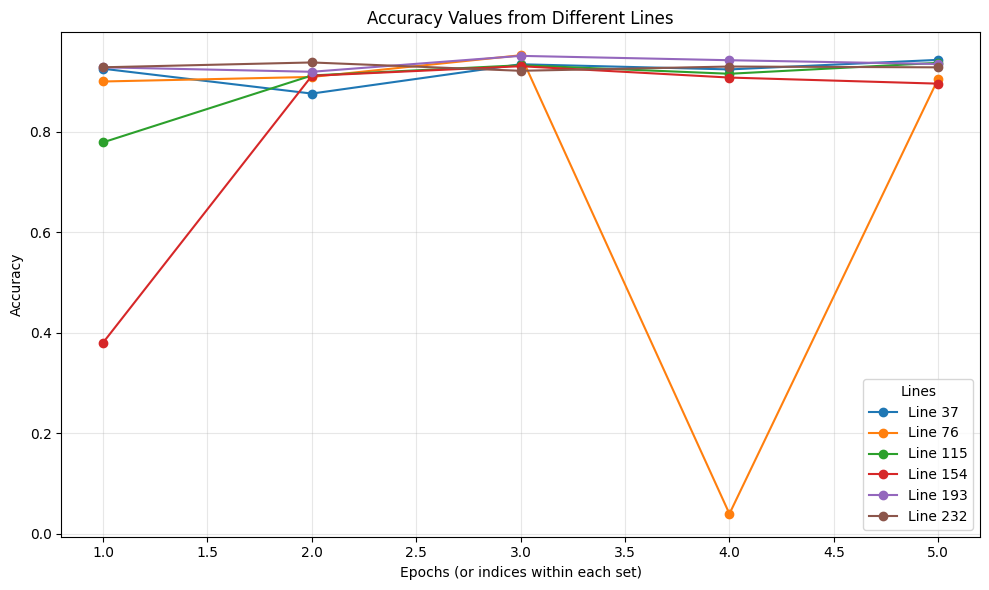

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the lines
lines = [
    [0.9258179664611816, 0.8763362765312195, 0.9347209930419922, 0.9244350790977478, 0.9434680342674255],
    [0.9003887176513672, 0.9094589948654175, 0.9526200890541077, 0.039766743779182434, 0.9058880805969238],
    [0.7792354822158813, 0.9123674035072327, 0.9327771663665771, 0.9157690405845642, 0.9375556707382202],
    [0.38038548827171326, 0.9117265939712524, 0.9308333992958069, 0.9082368016242981, 0.8960881233215332],
    [0.9286524057388306, 0.9197375774383545, 0.9514052271842957, 0.9427391290664673, 0.935206949710846],
    [0.9286524057388306, 0.9382895827293396, 0.9216814041137695, 0.9301854968070984, 0.9285656213760376]
]

# Line numbers corresponding to each set of accuracies
line_numbers = [37, 76, 115, 154, 193, 232]

# Generate the chart
plt.figure(figsize=(10, 6))

# Plot each line of accuracies
for i, acc in enumerate(lines):
    plt.plot(range(1, len(acc) + 1), acc, marker='o', label=f'Line {line_numbers[i]}')

# Add labels, title, and legend
plt.xlabel('Epochs (or indices within each set)')
plt.ylabel('Accuracy')
plt.title('Accuracy Values from Different Lines')
plt.legend(title="Lines", loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()

# Display the chart
plt.show()
